### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing Dataset

In [2]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col=['DATE'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<Axes: xlabel='DATE'>

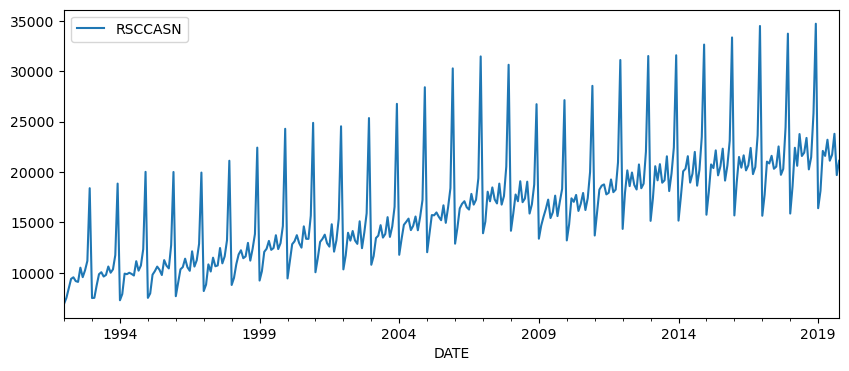

In [5]:
df.plot(figsize=(10,4))

In [6]:
test_length = 18 
test_index = len(df)- test_length

In [7]:
test_index

316

### Train test split

In [8]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
scaled_train = scaler.fit_transform(train)

In [12]:
scaled_test = scaler.transform(test)

### Creating Generator

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #to remove warnings

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 12
batch_size = 1

In [16]:
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

test_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length,batch_size=batch_size)

In [17]:
X,y = train_generator[0]

In [18]:
y

array([[0.02047633]])

### Creating the Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [20]:
n_features = 1

In [21]:
model = Sequential()

model.add(LSTM(100,input_shape = (length,n_features), activation='relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [24]:
model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0100
Epoch 2/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0177 - val_loss: 0.0023
Epoch 3/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0041
Epoch 4/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 8.2111e-04
Epoch 5/20
304/304 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/20
304/304 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 8.0492e-04
Epoch 7/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 2.1733e-04
Epoch 8/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/20
304/304 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0030


In [25]:
loss_df = pd.DataFrame(model.history.history)

<Axes: >

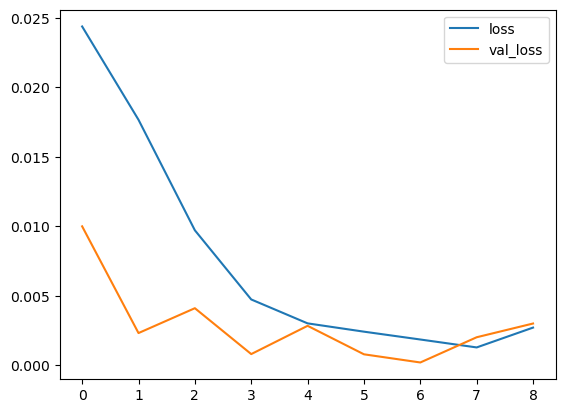

In [26]:
loss_df.plot()

### Making predictions

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 7ms/step


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

/var/folders/qy/6lbwh02n7dz0qktxghpcfj0h0000gn/T/ipykernel_91410/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='DATE'>

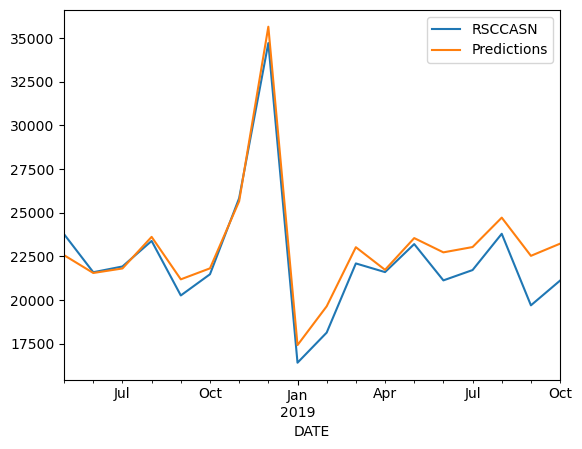

In [30]:
test.plot()

### Forecasting

In [31]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [32]:
full_generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=batch_size)

In [33]:
model.fit(full_generator,epochs=20)

Epoch 1/20
322/322 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 2/20
322/322 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 3/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 4/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 5/20
322/322 [==============================] - 0s 1ms/step - loss: 8.8358e-04
Epoch 6/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 7/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 8/20
322/322 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 9/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 10/20
322/322 [==============================] - 0s 1ms/step - loss: 9.7236e-04
Epoch 11/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 12/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 13/20
322/3

In [34]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch2 = scaled_full_data[-length:]
current_batch2 = first_eval_batch2.reshape((1, length, n_features))

for i in range(periods):
    current_pred2 = model.predict(current_batch2)[0]
    forecast.append(current_pred2) 
    current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]],axis=1)

1/1 [==============================] - 0s 7ms/step


In [35]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS',)

In [43]:
forecast2 = full_scaler.inverse_transform(forecast)

In [44]:
forecast_df = pd.DataFrame(data=forecast2,index=forecast_index,
                           columns=['Forecast'])

<Axes: xlabel='DATE'>

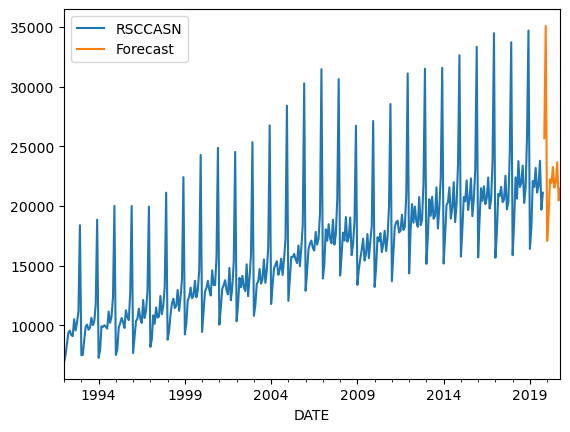

In [46]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

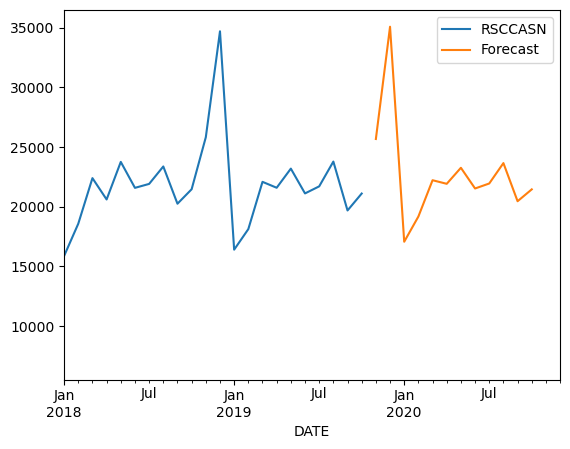

In [47]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')